# Blue Book for Bulldozers

The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations.

* Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers.
* The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.


The data for this competition is split into three parts:
* **Train.csv** is the training set, which contains data through the end of 2011.
      The key fields are in train.csv are:
    * 1.SalesID: the uniue identifier of the sale
    * 2.MachineID: the unique identifier of a machine.A machine can be sold multiple times
    * 3.saleprice: what the machine sold for at auction (only provided in train.csv)
    * 4.saledate: the date of the sale
    
    

* **Valid.csv** is the validation set, which contains data from January 1, 2012 - April 30, 2012.
* **Test.csv** is the test set. It contains data from May 1, 2012 - November 2012. 

## **Load libraries and import data**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics,tree
import matplotlib.pyplot as plt
from fastai.imports import *

In [3]:
PATH = "../dataset/bulldozers/"

In [4]:
!ls {PATH}

Data Dictionary.xlsx             ValidSolution.csv
Test.csv                         median_benchmark.csv
Train.csv                        random_forest_benchmark_test.csv
Valid.csv


In [5]:
# load data parsing in the Saledate and low_memory reads the types.
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])



* Save the dataframe as feather format, temporaray file to RAM ,to load the data faster if kernal shuts down.

In [6]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

In [7]:
df_raw = pd.read_feather('tmp/bulldozers-raw')

In [8]:
# displays all rows , without truncating the dataframe.
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [9]:
# .T displays transpose of the df
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,None,None,None,None,None
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


#### The evaluation of the dataset requires the root mean squared log error (more concerned with the ratio of saleprice variation) so convert the intial saleprice into log.

In [10]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [11]:
display_all(df_raw.tail().T)

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,9.25913,9.30565,9.3501,9.10498,8.95545
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,None,None,None,None,None
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


## What is a random forest? 
* universal machine learning technique
* predict any kind: categorical variable (classification),continuous variable (regression).
* predict with columns of any kind both structured and unstructured data
* does not generally overfit too badly
* null or very few statistical assumptions like normal distribution of data,linear relationship, or have specified interactions.

**scikit-learn**-popular and important package for machine learning in Python.
Steps(mostly the same for most of thescikit-learn):
1. Create an instance of an object
2. Call fit by passing in the independent variables (preditor variable) and dependent variable (predicted variable).


* **RandomForestRegressor** — for predicting continuous variables (i.e. regression)
* **RandomForestClassifier** — for predicting categorical variables (i.e. classification



Running a RandomForestRegressor on the dataframe,
 m = RandomForestRegressor(n_jobs=-1)
 m.fit(df_raw.drop("SalePrice",axis=1),df_raw.SalePrice)
will result in **ValueError:** could not convert string to float: 'Conventional' 

This requires to modify the dataframe further and convert the strings to float, adjust date-time objects, null values etc.

## Pre-processing the data.


### 1. Extracting date fields


The add_datepart method extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

In [12]:
# Extracts date fields,'saleYear', 'saleMonth','saleWeek', 'saleDayofyear','saleIs_month_end','saleElapsed' etc.
add_datepart(df_raw,"saledate")
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [13]:
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


### 2. Conversion to categorical variables 

After the date variable, the dataframe still has columns with categorical variables.Pandas concept of category data type by default wont turn anything into a category .
Fast.ai provides a function called train_cats which creates categorical variables for everything that is a String. Behind the scenes, it creates a column that is an integer. 

In [14]:
# convert strings into categorical numbers behind the scene w/o visually affecting the data.
train_cats(df_raw)

In [15]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

In [16]:
# inplace change the existing dataframe rather than returning a new one.ordered will order the categories
df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered=True, inplace=True)

### 3. Processing null values

**Detect** null values in each:
* add number of empty values
* Sort them by index using pandas.Series.sort_index
* divide by a length of dataset.



In [17]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

**Rectify:**
* handle missing continuous values, and split the dependent variable into a separate variable.
* For numeric data type if there is null column, add a new column with a name with _na appended at the end and set it to 1 if it is missing; 0 otherwise (boolean). And then add median to the missing variable.
* For categorical variables, Pandas automatically sets to -1 . Later use numericalize(if it is not numeric and is a categorical type,) to replace the column with its code plus 1.


In [18]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [19]:
# run random forest after preprocessing the data.
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.983108259869507

m.score will return r² value, which illustrates how using all the data can lead to overfitting. 
A validation set helps with overfitting.

In [20]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()
# same as Kaggle's test set size, splits data into two in order.
n_valid = 12000  
n_trn = len(df)-n_valid

raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

## Defining errors


In [21]:
# function defining the root mean square error
def rmse(x,y): return math.sqrt(((x-y)**2).mean())
# function defines the error values,m.score gives r2 values and rmse() gives rootmeansquare.
def print_score(m):
    res = [rmse(m.predict(X_train), y_train), 
           rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), 
           m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)


In [22]:
# Base model
#%time gives the runtime.
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 5s, sys: 416 ms, total: 1min 5s
Wall time: 19.6 s
[0.09036234031469749, 0.24788339380365593, 0.9829348634917461, 0.8902655879693754]


## Speeding things up

* taking in a random sample using "subset" for training without changing the validation set.
   

In [23]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [24]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.57 s, sys: 25.7 ms, total: 2.59 s
Wall time: 889 ms
[0.11206484196582216, 0.36296222118035654, 0.9723721006635376, 0.7647276871056112]


## Random Forest

### 1. Single tree

In [25]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5243165906163656, 0.580074568231208, 0.39522156199372005, 0.39908143030054055]


A tree consists of:

* The first line indicates the binary split criteria
* samples size
* Darker color indicates higher value
* value is average value of the dependent variable,average of the log of price in this case.
* The mean squared error mse.


The split is picking a variable and the value to split on, such that the two groups are as different to each other as possible and the weighted average of the nodes determines the best split.

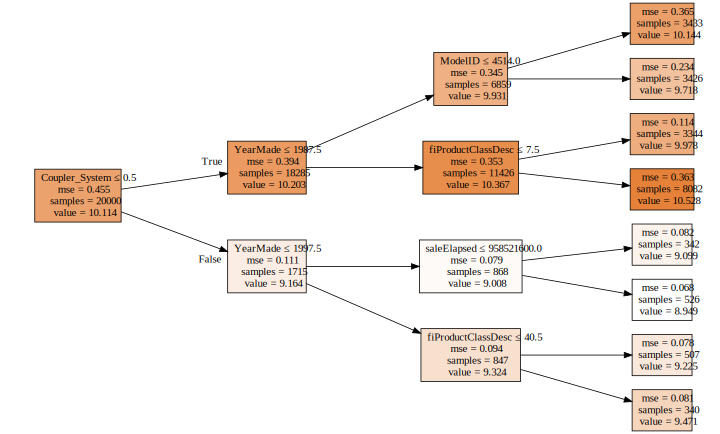

In [26]:
# visual representation
draw_tree(m.estimators_[0], df_trn, precision=3)

Increasing the depth of the tree or making the tree bigger will make the training set look great but the validation set is worse than our original model so we use the method of **Bagging** of multiple trees to get more generalizable results.

In [27]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[5.756054031998178e-17, 0.49379637234646195, 1.0, 0.5645445161492455]


## Bagging
* create less predictive models
* the predictions from each model are not correlated with each other, the models will have profound different insights into the relationships in the data.
* Averaging the models effectively give insights from each of them.
* This is a technique for Ensembling.


In scikit-learn, there is another class called **ExtraTreeClassifier** which is an extremely randomized tree model. Rather than trying every split of every variable, it randomly tries a few splits of a few variables which makes training much faster and it can build more trees — better generalization.

##### Start with Base Model.

In [28]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.1099996671416272, 0.35493884978729623, 0.9733809935852714, 0.7750142306980712]


##### Prediction from single tree

In [29]:
# np.stack concatenates, 
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0]   


array([9.047821, 9.047821, 9.615805, 9.076809, 9.350102, 9.047821, 9.305651, 9.21034 , 9.047821, 9.392662])

In [30]:
# default of 10 trees , and validation set sample size is 12000
preds.shape

(10, 12000)

In [31]:
# Mean of predictions gives a better prediction than individual prediction
np.mean(preds[:,0]), y_valid[0]

(9.214265539622781, 9.104979856318357)

#### Setting No of trees.

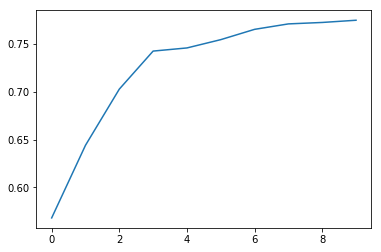

In [32]:
# plot of R² values given first i trees. 
# As we add more trees, R² improves,but flattens out.
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

### 1

In [33]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.1016515034589458, 0.3660607494414807, 0.9772680489763801, 0.7606936057888121]


### 2

In [34]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09600688975052799, 0.3541956368719362, 0.9797225238221694, 0.7759554478409564]


### 3

In [35]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0937928428733492, 0.3530383094135935, 0.9806469910220794, 0.7774171784092965]


* adding trees does not make the model better.
* does not get worse but no more improvement is noticied

## Out-of-bag (OOB) score

out-of-bag (OOB) error can handle:
* small size of data
* the validation set is for a different time period
* overfitting

OOB score will come in handy when setting hyper parameters
Scikit-learn has a function called grid search which,runs the model on every possible combination of all the hyper parameters and tells which one is the best. OOB score is a great choice for understanding which one is the best.


In [36]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09632678291652141, 0.3575026003568847, 0.9795871703547615, 0.7717523135729316, 0.8549777205902374]


## Subsampling

Subsampling is used for both speeding up and prevent overfitting.
* take a totally different subset of datasample each time

Difference in earlier sampling and the current sampling is , the data sample used before is for all trees in the model and here it is  limited  to a different random subset per tree. 

In [37]:
#Return to using  full dataset, removing the "subset=30000" set earlier
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [38]:
set_rf_samples(20000)

In [39]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 7.12 s, sys: 344 ms, total: 7.46 s
Wall time: 3.88 s
[0.2413438309259492, 0.27806363130063344, 0.8782673068082629, 0.8619182272586436, 0.8655468288939011]


In [40]:
# each tree sees additional data, adding additional trees is beneficial
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.22710622904156438, 0.2608961051577067, 0.8922064143868671, 0.8784421065361341, 0.8807087931822246]


### Over-fitting avoidance method:

## 1. Tree building parameters

* min_sample_leaf : normally 1, 3, 5, 10, 25, but it is relative to your overall dataset size.
* max_feature : using a sample of columns for each split, so the less correlated the trees the better,Good values to use are 1, 0.5, log2, or sqrt

In [41]:
# revert back to original sample
reset_rf_samples()

#### min_sample_leaf 

In [42]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)


[0.07854434549146956, 0.23931724534948176, 0.9871066825330652, 0.897718764709532, 0.908249934212387]


In [43]:
# min_sample_leaf set to 5
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1406507510132836, 0.2340332253019946, 0.9586553864431355, 0.9021855517136511, 0.9069923814034097]


In [44]:
# min_sample_leaf set to 3
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11497627774603286, 0.23337187042517127, 0.9723718811628982, 0.9027375986158606, 0.9084238621087601]


#### max_feature

In [45]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11916851336142997, 0.22942815728704335, 0.970320411920324, 0.9059970662093986, 0.9115332885754144]


## Model interpretation

### 1. Confidence based on tree variance
* consider standard deviation of prediction of trees, the standard deviation is high means each tree is giving a very different estimate of this row’s prediction.
* For model interpretation, there is no need to use the full dataset because we do not need a massively accurate random forest — we just need one which indicates the nature of relationships involved.the sample size should be large enough that if you call the same interpretation commands multiple times, you do not get different results back each time. In practice, 50,000 is a high number.

In [46]:
set_rf_samples(50000)

In [47]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20590897791153345, 0.24904744192869427, 0.9113894582416382, 0.8892325533970039, 0.89433335884478]


In [48]:
# same prediction as before
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.05 s, sys: 26 ms, total: 1.07 s
Wall time: 1.07 s


(9.293478258115766, 0.33609321897404193)

The looping through the trees slows down the system, so we use parallel_trees for parallel processing

In [49]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 71.1 ms, sys: 72.2 ms, total: 143 ms
Wall time: 652 ms


(9.293478258115766, 0.33609321897404193)

In order to see how prediction confidence varies, add the different predictions into the dataset,i.e add the standard deviation of the predictions and predictions themselves (the mean) as new columns



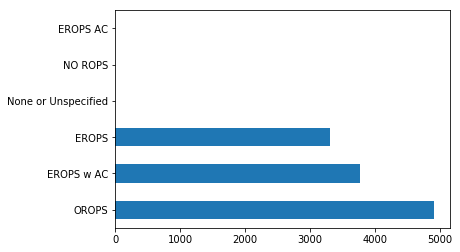

In [50]:
# copy of validation set
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
# for enclosure column
x.Enclosure.value_counts().plot.barh();

In [51]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.839624,0.278103
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.576179,0.263531
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.682361,0.220787


From above:
* Prediction and the sale price are close to each other on average
* Standard deviation varies a little bit


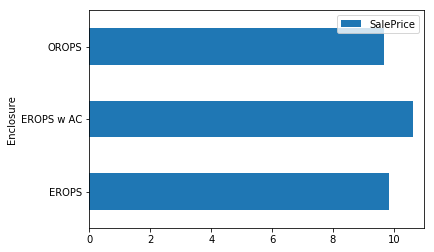

In [52]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

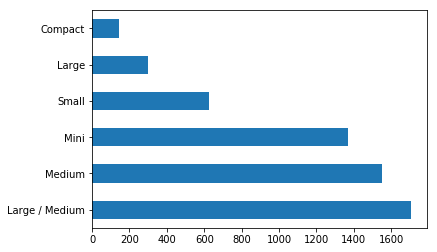

In [53]:
# for product size
x.ProductSize.value_counts().plot.barh();

In [54]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.866791,0.353831
Large,10.470589,10.389625,0.367993
Large / Medium,10.691871,10.650984,0.296751
Medium,10.681511,10.618176,0.287753
Mini,9.535147,9.560693,0.244866
Small,10.324448,10.328673,0.320398


On average, predicting bigger number means standard deviation would be higher. So we are sorting by ratio of standard deviations rather than preditions.

In [55]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.035861
Large             0.035419
Small             0.031020
Large / Medium    0.027861
Medium            0.027100
Mini              0.025612
dtype: float64

Predictions are less accurate for "Large" and "Compact"

## 2. Feature importance 

*  Tells which columns matter

In [56]:
fi = rf_feat_importance(m, df_trn); fi[:10]


,cols,imp
5,YearMade,0.173414
13,ProductSize,0.104830
37,Coupler_System,0.102163
14,fiProductClassDesc,0.075636
2,ModelID,0.058517
38,Grouser_Tracks,0.055382
63,saleElapsed,0.051380
10,fiSecondaryDesc,0.046982
39,Hydraulics_Flow,0.038931
19,Enclosure,0.031869


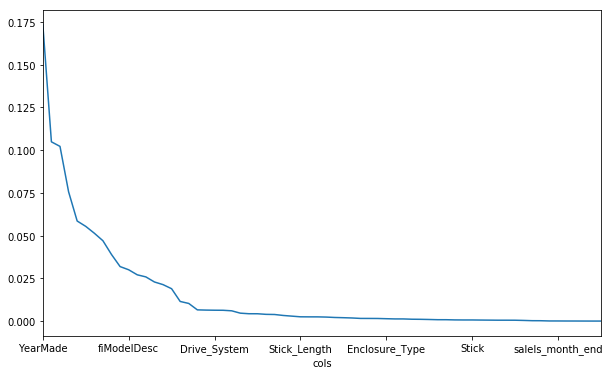

In [57]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

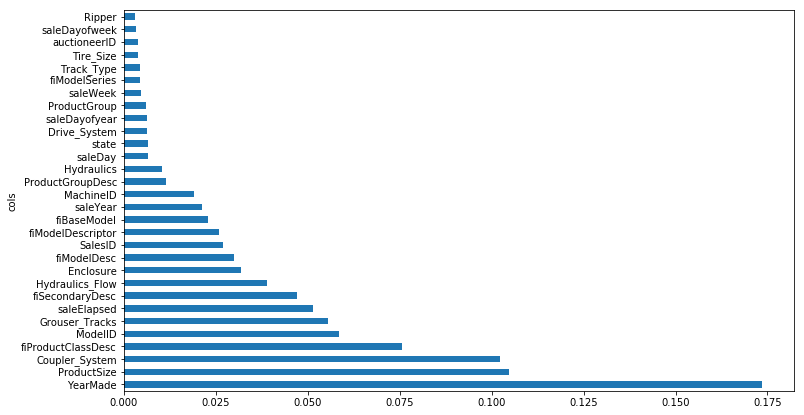

In [58]:
# Further plotting as bar graph
def plot_fi(fi): 
  return fi.plot('cols','imp','barh', figsize=(12,7), legend=False)
plot_fi(fi[:30]);

In [59]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

23

In [60]:
# new dataframe with required features.
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)


In [61]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20758401132474927, 0.24676944761565597, 0.909941931981219, 0.8912496278366862, 0.8936138053737638]


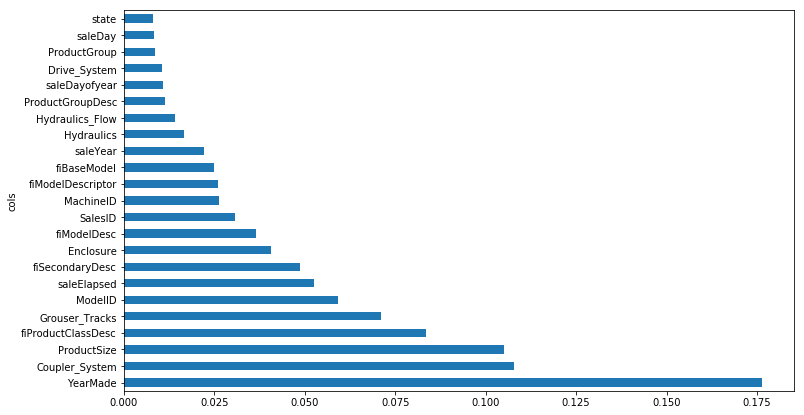

In [62]:
# again plotting the feature importance with modified data.
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);


* By removing redundant columns, we are removing sources of collinearity. 

## 3.One-hot encoding

proc_df's optional max_n_cat argument will turn some categorical variables into new columns.Random forest recognises the categorical variable (converted initially) as numbers and to get to apppropriate variable requires many splits which is not efficient and wasting tree computation. Wasting tree computation matters because every time we do a split, we are halving the amount of data and at least that we have to do more analysis.

In [63]:
df_trn2, y_trn, nas = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20693990553705588, 0.2538158205017965, 0.9104999415172831, 0.8849503369970028, 0.8928234930946246]


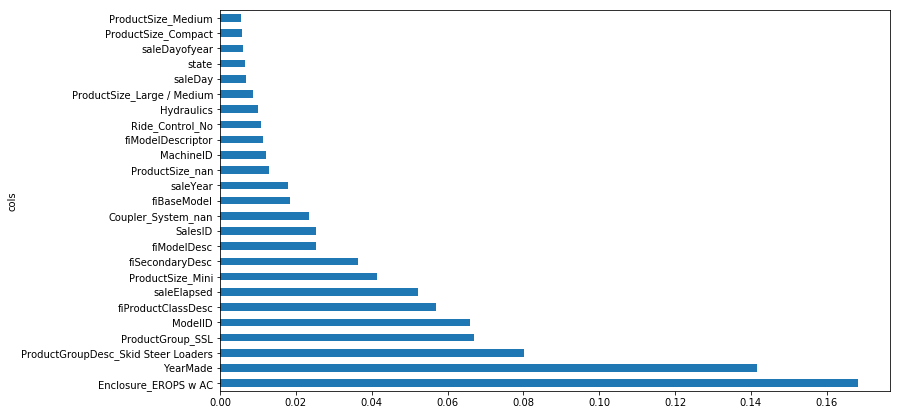

In [64]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

## 4. Removing redundant feature
Cluster analysis is something where you are trying to look at objects, they can be either rows in the dataset or columns and find which ones are similar to each other. 

In [65]:
from scipy.cluster import hierarchy as hc

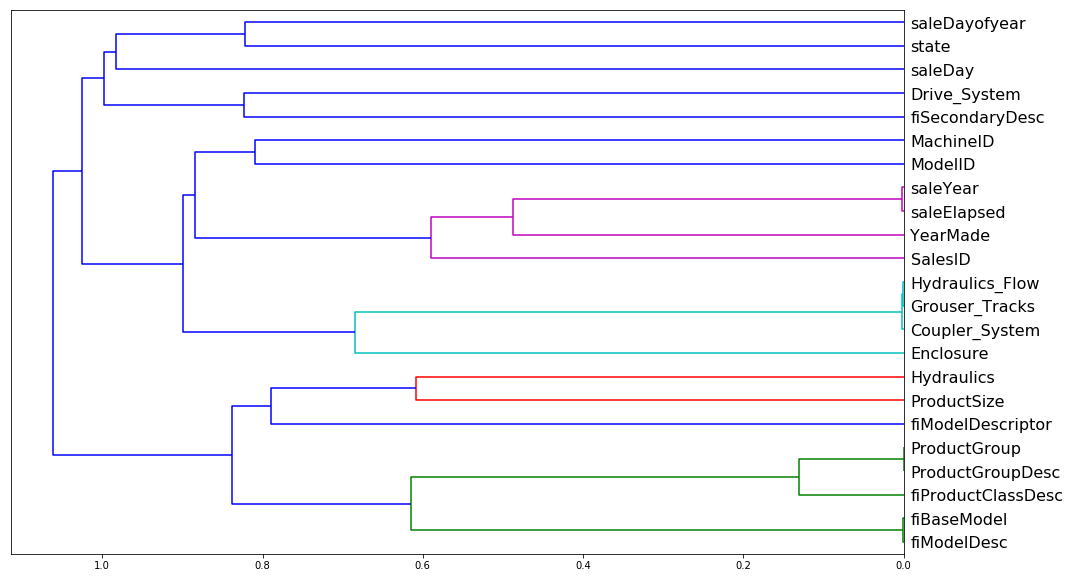

In [66]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [67]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [68]:
#removing each variable one at a time
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.8886042188557706
saleElapsed 0.8869096136340351
fiModelDesc 0.8888011621855192
fiBaseModel 0.889922319161887
Grouser_Tracks 0.8900600191929244
Coupler_System 0.8907724882405909


In [69]:
#after selecting one from the releated varible, get oobscore for the data.
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.8892179235325935

In [70]:
#run the model again after dropping the columns from the dataframe.
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [71]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [72]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

In [73]:
reset_rf_samples()

In [74]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1251435588110299, 0.22770528971138557, 0.9672695611398645, 0.9074035763576871, 0.9087829188695806]


## 5.Partial dependence
Feature dependance on dependent variable

In [77]:
#from pdpbox import pdp
#from plotnine import *
